In [1]:
from optim import Apollo
import math
import json
import random
import numpy as np

import torch
import torch.nn as nn
import torchvision
from torch.optim import SGD
from torchvision import datasets, transforms
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
import time

from tqdm import trange

In [2]:
#This notebook will be a simple introduction to Classification: Testing On MINST Dataset
# Using 2 optimizers.. SGD vs Apollo (1st Order vs 2nd Order)

#In the future may plan to use momentum/context to better approximate the hessian in Apollo method

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [4]:

train_set = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)
print(type(train_set))

test_set = torchvision.datasets.MNIST(
    root = './data/MNIST',
        train = True,
        download = True,
        transform = transforms.Compose([
            transforms.ToTensor()                                 
        ])

)

<class 'torchvision.datasets.mnist.MNIST'>


In [5]:
batch_size_train = 32
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_train,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test,
                                          shuffle=True, num_workers=2)

In [6]:
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)
class BobNet(torch.nn.Module):
  def __init__(self):
    super(BobNet, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [8]:
model = BobNet()
model2 = Net().cuda()
modelapollo = Net().cuda()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.0015, momentum=0.9)

In [9]:
Batchsize = batch_size_train
loss_function = nn.CrossEntropyLoss()
optim = Apollo(modelapollo.parameters(), lr = 0.5, eps = 1e-4, weight_decay = 5e-4, warmup = 100,
               init_lr = 0.01)



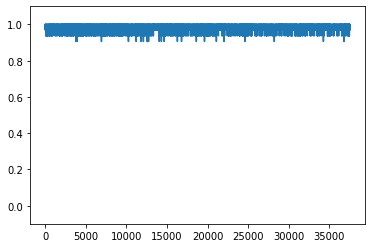

In [14]:
losses, accuracies = [], []
curr_time = time.time()

for epoch in range(20):
    for batch_idx, (data, target) in enumerate(train_loader):

      X = data.to(device).cuda()
      Y = target.to(device).cuda()
      model2.zero_grad()
      out = model2(X)
      cat = torch.argmax(out, dim=1)
      accuracy = (cat == Y).float().mean()
      loss = loss_function(out, Y)
      loss = loss.mean()
      loss.backward()
      optimizer.step()
      loss, accuracy = loss.item(), accuracy.item()
      losses.append(loss)
      accuracies.append(accuracy)
      #t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
    
plt.ylim(-0.1, 1.1)
#plt.plot(losses)
plt.plot(accuracies)
result_time = time.time() - curr_time


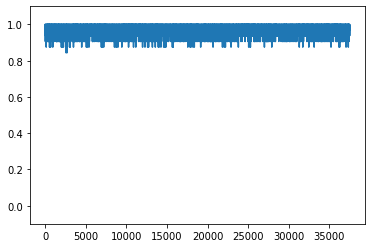

In [15]:
a_losses, a_accuracies = [], []
i_time = time.time()

for epoch in range(20):
    for batch_idx, (data, target) in enumerate(train_loader):
      modelapollo.zero_grad()
      X = data.to(device).cuda()
      Y = target.to(device).cuda()
      
      out = modelapollo(X)
      cat = torch.argmax(out, dim=1)
      accuracy = (cat == Y).float().mean()
      loss = loss_function(out, Y)
      loss = loss.mean()
      loss.backward()
      optim.step()
    
      loss, accuracy = loss.item(), accuracy.item()
      a_losses.append(loss)
      a_accuracies.append(accuracy)
      #t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1.1)
#plt.plot(a_losses)
plt.plot(a_accuracies)
final_time = time.time() - i_time


In [16]:
print("Apollo time: " + str(final_time))
print("S.G.D time: " + str(result_time))

Apollo time: 185.5001735687256
S.G.D time: 141.50123023986816


In [ ]:
res_sgd = torchvision.models.resnet50()
res_apollo = torchvision.models.resnet50()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


sgd_net = Net().cuda()
apollo_net = Net().cuda()

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

In [ ]:
losses, accuracies = [], []

for epoch in range(5):
    for batch_idx, (data, target) in enumerate(trainloader):

      X = data.to(device).cuda()
      Y = target.to(device).cuda()
      sgd_net.zero_grad()
      out = sgd_net(X)
      cat = torch.argmax(out, dim=1)
      accuracy = (cat == Y).float().mean()
      loss = loss_function(out, Y)
      loss = loss.mean()
      loss.backward()
      optimizer.step()
      loss, accuracy = loss.item(), accuracy.item()
      losses.append(loss)
      accuracies.append(accuracy)
      #t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
    
plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)


In [ ]:
losses, accuracies = [], []

for epoch in range(5):
    for batch_idx, (data, target) in enumerate(trainloader):

      X = data.to(device).cuda()
      Y = target.to(device).cuda()
      apollo_net.zero_grad()
      out = apollo_net(X)
      cat = torch.argmax(out, dim=1)
      accuracy = (cat == Y).float().mean()
      loss = loss_function(out, Y)
      loss = loss.mean()
      loss.backward()
      optimizer.step()
      loss, accuracy = loss.item(), accuracy.item()
      losses.append(loss)
      accuracies.append(accuracy)
      #t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
    
plt.ylim(-0.1, 1.1)
#plt.plot(losses)
plt.plot(accuracies)
